In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum as _sum, avg, count, round, to_date, date_format
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans 
from matplotlib.cm import get_cmap
import matplotlib.patches as patches
import warnings
warnings.filterwarnings('ignore')


# Initialize Spark session
spark = SparkSession.builder \
    .appName("Customer Purchase Behavior Analysis") \
    .getOrCreate()

# Define a function to print in green
def print_green(text):
    print(f"\033[92m{text}\033[0m")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/01 17:38:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Problem Statement 2: Customer Purchase Behavior Analysis
**Objective**: Analyse and report on customer purchase behaviours to understand spending patterns and customer segmentation.

**Description:**
1.	Use transactions.csv to analyse customer purchasing behaviour, including total spending, average transaction amount, and frequency of purchases.
2.	Cross-reference with customers.csv to segment customers by country and assess how geographic location impacts their purchasing patterns.

**Expected Deliverables:**
- A report summarizing top-spending customers, spending distribution by country, and notable trends or patterns in purchasing behaviour.


In [3]:
# Load data into Spark DataFrames
customers_df = spark.read.csv("Cleaned_data/cleaned_customers.csv", header=True, inferSchema=True)
transactions_df = spark.read.csv("Cleaned_data/cleaned_transactions.csv", header=True, inferSchema=True)
products_df = spark.read.csv("Cleaned_data/cleaned_products.csv", header=True, inferSchema=True)

# Validate the data
customers_df.show(5,truncate=False)
transactions_df.show(5,truncate=False)
products_df.show(5,truncate=False)

+------------------------------------+-----------------+----------------------+---------------+-----------+
|Customer_ID                         |Name             |Email                 |Phone          |Country    |
+------------------------------------+-----------------+----------------------+---------------+-----------+
|003ca69a-991c-4c11-899a-51bb7365499d|Erica Diaz       |hurleyanna@example.com|+964-8545044941|Iraq       |
|006af455-013b-4c09-a6df-15ca3d41010f|Jason Jackson    |dylanduran@example.com|+63-2484285464 |Philippines|
|00fc38f7-b5c7-465c-839b-a55185f2635f|Heather Schneider|larajohn@example.org  |+264-7935879728|Namibia    |
|015cc4e1-5cf8-441c-80ad-ca3536c53e9a|Matthew Wilson   |timothyho@example.org |+357-8883554148|Cyprus     |
|01d13428-d511-4c3d-90c7-b5624931ff48|Robert Contreras |lydia12@example.com   |unknown        |Swaziland  |
+------------------------------------+-----------------+----------------------+---------------+-----------+
only showing top 5 rows

+--

## 1. Total Spending, Average Transaction Amount, and Purchase Frequency

In [4]:
# Calculate total spending, average transaction amount, and purchase frequency per customer

# Aggregate transaction data to compute key metrics for each customer
customer_spending_df = transactions_df.groupBy("Customer_ID") \
    .agg(
        _sum("Amount").alias("Total_Spending"),  # Calculate the total spending by summing up the 'Amount' column
        round(avg("Amount"), 2).alias("Average_Transaction_Amount"),  # Compute the average transaction amount, rounded to 2 decimal points for precision
        count("Transaction_ID").alias("Purchase_Frequency")  # Count the number of transactions to determine purchase frequency
    )

# Combine customer spending metrics with customer details to facilitate country-based segmentation and analysis
customer_behavior_df = customer_spending_df.join(customers_df, on="Customer_ID", how="inner")

# Select relevant columns to display the combined customer spending metrics and segmentation data
print_green("Total Spending, Average Transaction Amount, and Purchase Frequency for Each Customer")
customer_behavior_df.select(["Customer_ID", "Name", "Total_Spending", "Average_Transaction_Amount", "Purchase_Frequency", "Country"]).show(5)


Total Spending, Average Transaction Amount, and Purchase Frequency for Each Customer
+--------------------+--------------+--------------+--------------------------+------------------+--------------------+
|         Customer_ID|          Name|Total_Spending|Average_Transaction_Amount|Purchase_Frequency|             Country|
+--------------------+--------------+--------------+--------------------------+------------------+--------------------+
|ff3a6c5b-77ac-485...|     Amy Garza|        1544.0|                     308.8|                 5|    French Polynesia|
|06f70108-4508-466...|Heather Brandt|         834.0|                     208.5|                 4|        Cook Islands|
|d1c31505-73ab-4e7...|  Ian Matthews|         582.0|                     291.0|                 2|                Guam|
|0f4ff1f7-40fc-422...| Kristin Ochoa|         700.0|                    233.33|                 3|Palestinian Terri...|
|ba395db1-0232-4cb...|    Chad Tyler|         395.0|                     19

## 1. Top 20 most active customers based on purchase frequency

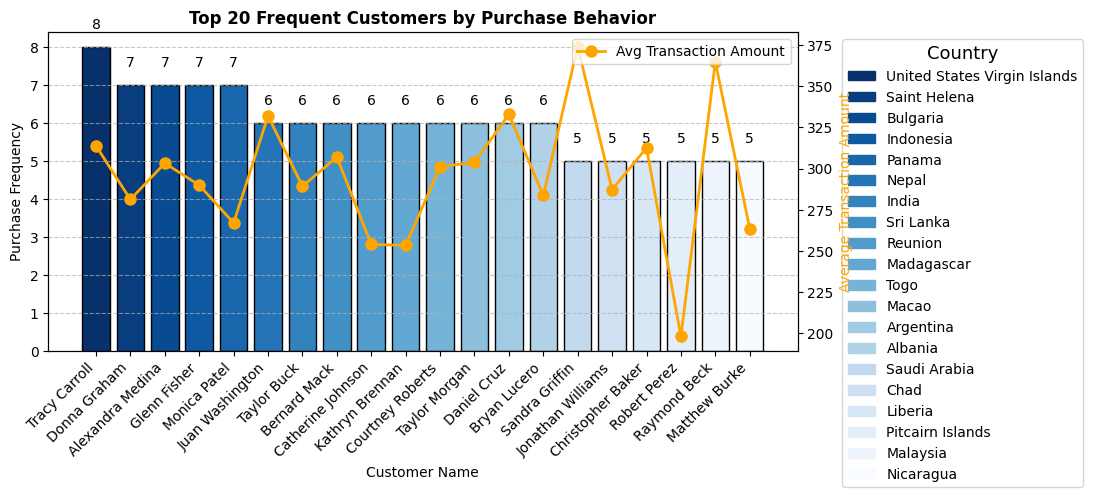

In [5]:
# Join the customer spending data with the customer details to get names and countries
# This step merges customer spending behavior data with customer details to enrich the dataset with customer names and countries.
customer_details_df = customers_df.select("Customer_ID", "Name", "Country")
customer_behavior_df = customer_spending_df.join(customer_details_df, on="Customer_ID", how="inner")

# Identify top 20 most active customers based on purchase frequency
# Sorting the merged dataset by purchase frequency to identify the top 10 customers who have made the most purchases.
top_active_customers_df = customer_behavior_df.orderBy(col("Purchase_Frequency").desc()).limit(20)
top_active_customers_pd_df = top_active_customers_df.toPandas()

# Define a colormap for shades of blue and reverse it
# Generate a color map for visual differentiation based on country, using shades of blue to represent different countries.
cmap = get_cmap('Blues')
unique_countries = top_active_customers_pd_df['Country'].unique()
colors = cmap(np.linspace(0, 1, len(unique_countries)))[::-1]  # Reverse the colormap to ensure the darkest shade is used first
color_dict = dict(zip(unique_countries, colors))

# Map the colors to the DataFrame based on country
# Add a new column to the DataFrame to assign a color to each customer based on their country for visualization purposes.
top_active_customers_pd_df['Color'] = top_active_customers_pd_df['Country'].map(color_dict)

# Create the bar chart with line plot for Purchase Frequency
# Initialize the figure and axis for plotting.
fig, ax1 = plt.subplots(figsize=(14, 5))

# Bar plot for Purchase Frequency
# Plot a bar chart to visualize the purchase frequency of the top 10 customers, with colors representing their countries.
bars = ax1.bar(
    top_active_customers_pd_df['Name'],
    top_active_customers_pd_df['Purchase_Frequency'],
    color=top_active_customers_pd_df['Color'],
    label='Purchase Frequency',
    edgecolor='black'
)

# Create a second y-axis for Average Transaction Amount
# Add a second y-axis to the same plot to display the average transaction amount alongside the purchase frequency.
ax2 = ax1.twinx()
lines = ax2.plot(
    top_active_customers_pd_df['Name'],
    top_active_customers_pd_df['Average_Transaction_Amount'],
    color='orange',
    marker='o',
    linestyle='-',
    linewidth=2,
    markersize=8,
    label='Avg Transaction Amount'
)

# Add labels on top of bars with integer values
# Annotate each bar with its height value to provide clear information on the purchase frequency for each customer.
for bar in bars:
    yval = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval + 0.05 * max(top_active_customers_pd_df['Purchase_Frequency']),
        f'{int(yval)}',  # Display the purchase frequency as an integer
        ha='center',
        va='bottom'
    )

# Customize the layout
# Set labels, titles, and gridlines to enhance the readability and presentation of the chart.
ax1.set_xlabel('Customer Name')
ax1.set_ylabel('Purchase Frequency')
ax1.set_title('Top 20 Frequent Customers by Purchase Behavior', fontweight='bold')
ax1.set_xticklabels(top_active_customers_pd_df['Name'], rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax2.set_ylabel('Average Transaction Amount', color='orange')

# Create a custom legend
# Add a legend to the plot to identify the colors representing different countries.
legend_patches = [patches.Patch(color=color_dict[country], label=country) for country in unique_countries]
ax1.legend(
    handles=legend_patches,
    title='Country',
    bbox_to_anchor=(1.05, 1),  # Move legend to the right side of the plot
    loc='upper left',
    title_fontsize='13',
    fontsize='10'
)
ax2.legend(loc='upper right')

# Adjust layout to make space for the legend
# Ensure the plot is adjusted to accommodate the legend and labels without overlapping.
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right space for legend
plt.show()


## 2. Top 20 spending customers with Average Transaction Amount

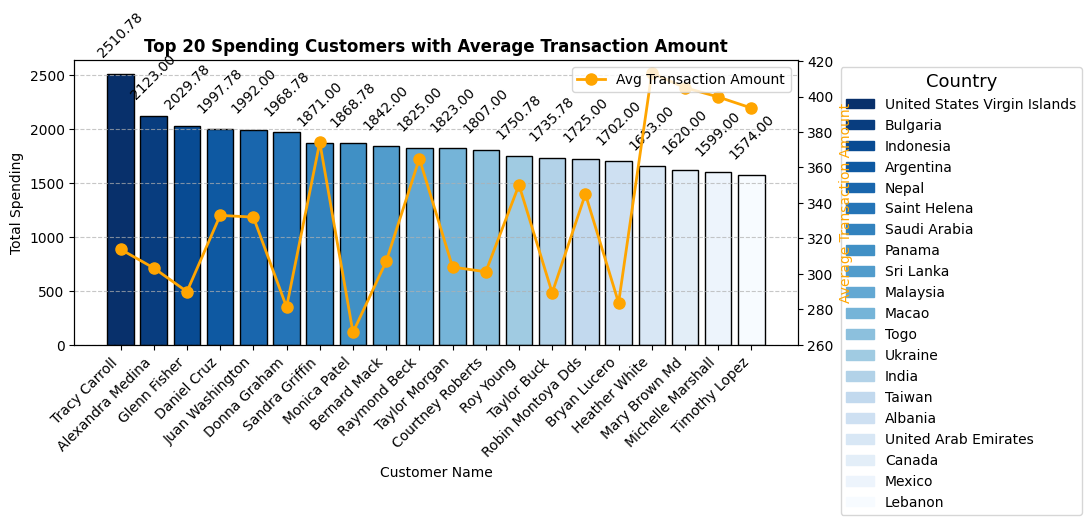

In [6]:
# Aggregate spending data to calculate total spending and average transaction amount per customer
customer_spending_df = transactions_df.groupBy("Customer_ID") \
    .agg(
        _sum("Amount").alias("Total_Spending"),
        avg("Amount").alias("Average_Transaction_Amount")
    )

# Join the aggregated spending data with customer details to enrich the dataset
customer_details_df = customers_df.select("Customer_ID", "Name", "Country")
customer_spending_with_details_df = customer_spending_df.join(
    customer_details_df,
    on="Customer_ID",
    how="inner"
)

# Identify top 20 customers based on total spending
top_customers_df = customer_spending_with_details_df.orderBy(col("Total_Spending").desc()).limit(20)
top_customers_pd_df = top_customers_df.toPandas()

# Define a colormap for shades of blue and reverse it
cmap = get_cmap('Blues')
unique_countries = top_customers_pd_df['Country'].unique()
colors = cmap(np.linspace(0, 1, len(unique_countries)))[::-1]  # Reverse the colormap for better contrast
color_dict = dict(zip(unique_countries, colors))

# Map the colors to the DataFrame based on country
top_customers_pd_df['Color'] = top_customers_pd_df['Country'].map(color_dict)

# Create the bar chart with line plot for Average Transaction Amount
fig, ax1 = plt.subplots(figsize=(14, 5))

# Bar plot for Total Spending
bars = ax1.bar(
    top_customers_pd_df['Name'],
    top_customers_pd_df['Total_Spending'],
    color=top_customers_pd_df['Color'],
    label='Total Spending',
    edgecolor='black'
)

# Create a second y-axis for Average Transaction Amount
ax2 = ax1.twinx()
lines = ax2.plot(
    top_customers_pd_df['Name'],
    top_customers_pd_df['Average_Transaction_Amount'],
    color='orange',
    marker='o', 
    linestyle='-',
    linewidth=2,
    markersize=8,
    label='Avg Transaction Amount'
)

# Add labels on top of bars with a slight tilt
for bar in bars:
    yval = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval + 0.05 * max(top_customers_pd_df['Total_Spending']),
        f'{yval:.2f}',
        ha='center',
        va='bottom',
        fontsize=10,
        rotation=45  # Tilt the label by 45 degrees
    )

# Customize the layout
ax1.set_xlabel('Customer Name')
ax1.set_ylabel('Total Spending')
ax1.set_title('Top 20 Spending Customers with Average Transaction Amount', fontweight='bold')
ax1.set_xticklabels(top_customers_pd_df['Name'], rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2.set_ylabel('Average Transaction Amount', color='orange')

# Create a custom legend
legend_patches = [patches.Patch(color=color_dict[country], label=country) for country in unique_countries]
ax1.legend(
    handles=legend_patches,
    title='Country',
    bbox_to_anchor=(1.05, 1),  # Move legend to the right side of the plot
    loc='upper left',
    title_fontsize='13',
    fontsize='10'
)
ax2.legend(loc='upper right')

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right space for legend

# Show the plot
plt.show()


## 3. Spending Distribution by Country

In [7]:
# Aggregate spending by country and round both the total spending and average transaction amount to 2 decimal points
# This step summarizes the spending data by country, providing rounded figures for easier interpretation and consistency.
country_spending_df = customer_behavior_df.groupBy("Country") \
    .agg(
        round(_sum("Total_Spending"), 2).alias("Total_Spending_By_Country"),  # Calculate and round total spending per country
        round(avg("Average_Transaction_Amount"), 2).alias("Avg_Transaction_Amount_By_Country"),  # Calculate and round average transaction amount per country
        count("Customer_ID").alias("Customer_Count_By_Country")  # Count the number of customers per country
    )

# Display the results
# Order by total spending in descending order to see which countries have the highest total spending.
# The results are then shown to provide a clear view of spending distribution by country.
print_green("Aggregated Spending Data by Country: Total Spending, Avg Transaction Amount, Customer Count")
country_spending_df = country_spending_df.orderBy(col("Total_Spending_By_Country").desc())
country_spending_df.orderBy(col("Customer_Count_By_Country").desc()).show()

Aggregated Spending Data by Country: Total Spending, Avg Transaction Amount, Customer Count
+--------------------+-------------------------+---------------------------------+-------------------------+
|             Country|Total_Spending_By_Country|Avg_Transaction_Amount_By_Country|Customer_Count_By_Country|
+--------------------+-------------------------+---------------------------------+-------------------------+
| Trinidad And Tobago|                  2469.78|                           286.24|                        6|
|               Congo|                   3668.0|                           293.31|                        6|
|               Macao|                   5187.0|                           269.19|                        5|
|   Equatorial Guinea|                   2603.0|                           292.67|                        5|
|Sao Tome And Prin...|                   2094.0|                            209.4|                        5|
|               Spain|              

# 4. Top 20 Countries by Number of Customers, Total Spending, and Avg Transaction Amount

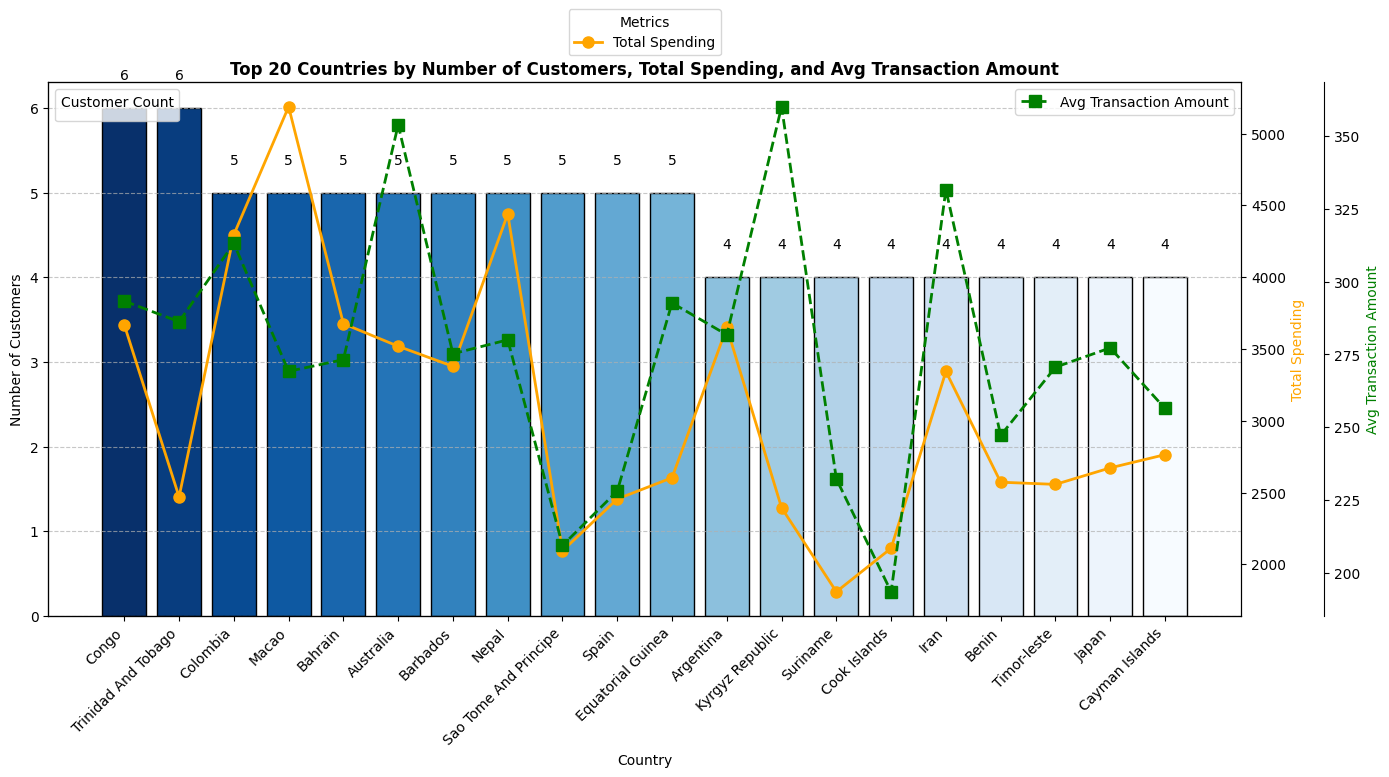

In [8]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
# Converting to Pandas DataFrame for ease of use with Matplotlib for visualization.
country_spending_pd_df = country_spending_df.toPandas()

# Sort by Customer_Count_By_Country in descending order and get the top 20 countries
# Sorting data to focus on the top 20 countries with the highest customer counts for detailed analysis.
top_countries_df = country_spending_pd_df.sort_values(by="Customer_Count_By_Country", ascending=False).head(20)

# Define a colormap for shades of blue
# Setting up a colormap to visually differentiate countries using a gradient of blue shades.
cmap = get_cmap('Blues')
# Create a color map for countries
num_countries = len(top_countries_df)
colors = cmap(np.linspace(0, 1, num_countries))[::-1]  # Use a range of shades for better visual distinction
color_dict = dict(zip(top_countries_df['Country'], colors))

# Plot the top 20 countries with the maximum number of customers
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar plot for Customer Count
# Creating a bar plot to show the number of customers for each country. Bars are colored based on the colormap.
bars = ax1.bar(
    top_countries_df['Country'],
    top_countries_df['Customer_Count_By_Country'],
    color=[color_dict[country] for country in top_countries_df['Country']],
    edgecolor='black'
)

# Add labels on top of bars
# Adding data labels on top of the bars to provide exact customer counts for clarity.
for bar in bars:
    yval = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval + 0.05 * max(top_countries_df['Customer_Count_By_Country']),
        f'{yval:.0f}',
        ha='center',
        va='bottom'
    )

# Create a second y-axis for Total Spending
# Adding a secondary y-axis to plot total spending data alongside customer counts.
ax2 = ax1.twinx()
lines_total_spending = ax2.plot(
    top_countries_df['Country'],
    top_countries_df['Total_Spending_By_Country'],
    color='orange',
    marker='o',
    linestyle='-',
    linewidth=2,
    markersize=8,
    label='Total Spending'
)

# Create a third y-axis for Average Transaction Amount
# Adding a third y-axis to plot the average transaction amount data. This axis is shifted outward for clarity.
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Adjust position to avoid overlap with other axes
lines_avg_transaction = ax3.plot(
    top_countries_df['Country'],
    top_countries_df['Avg_Transaction_Amount_By_Country'],
    color='green',
    marker='s',
    linestyle='--',
    linewidth=2,
    markersize=8,
    label='Avg Transaction Amount'
)

# Customize the layout
# Setting axis labels, title, and grid for the bar plot. Ensuring clear presentation of all plotted data.
ax1.set_xlabel('Country')
ax1.set_ylabel('Number of Customers')
ax1.set_title('Top 20 Countries by Number of Customers, Total Spending, and Avg Transaction Amount', fontweight='bold')
ax1.set_xticklabels(top_countries_df['Country'], rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Set labels for the secondary y-axes
ax2.set_ylabel('Total Spending', color='orange')
ax3.set_ylabel('Avg Transaction Amount', color='green')

# Add custom legends
# Creating and positioning legends for the bar plot, total spending line plot, and average transaction amount line plot.
ax1.legend(handles=[bars[0]], title='Customer Count', loc='upper left')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), title='Metrics')
ax3.legend(loc='upper right')

# Adjust layout to make space for the legends
# Ensuring that the plot layout is adjusted to accommodate the legends and make the visualization clear.
plt.tight_layout()
plt.show()


# 5. Grouping Customers based on their spending behaviour

Customer Segmentation by Spending Behaviour


Customer Count by Cluster
        Cluster_Name  Total_Customers
0  Moderate Spending              181
1      High Spending               53
2       Low Spending              193


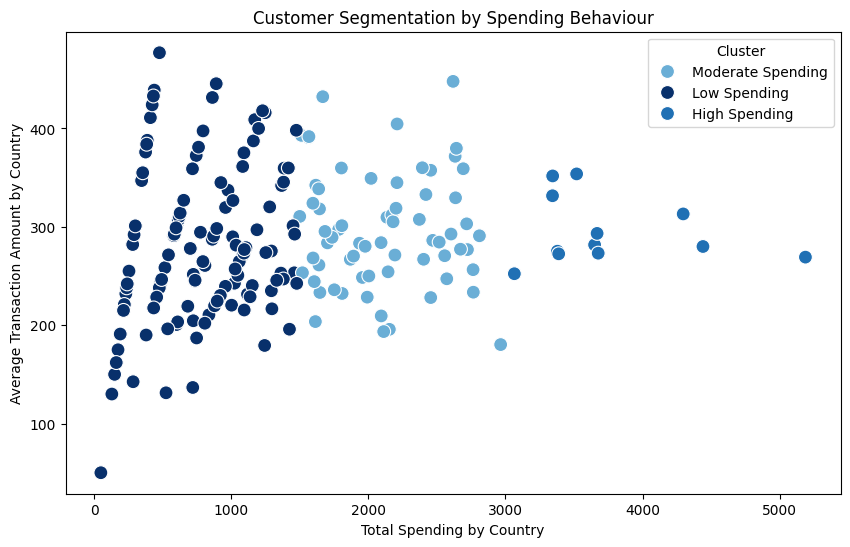

In [9]:

print_green('Customer Segmentation by Spending Behaviour')

# Step 1: Join transactions with customers to get customer details
transactions_customers_df = transactions_df.join(customers_df, on="Customer_ID", how="inner")

# Step 2: Aggregate data to calculate total spending and average transaction amount per customer
customer_aggregation_df = transactions_customers_df.groupBy("Customer_ID", "Name", "Country") \
    .agg(
        F.sum("Amount").alias("Total_Spending"),
        F.avg("Amount").alias("Average_Transaction_Amount")
    )

# Step 3: Create `customer_spending_with_details_df` by joining with the original customer details
customer_spending_with_details_df = customer_aggregation_df.join(customers_df.select("Customer_ID", "Email", "Phone"), on="Customer_ID", how="inner")

# Step 4: Calculate Total Spending, Average Transaction Amount, and Customer Count by Country
country_aggregation_df = customer_spending_with_details_df.groupBy("Country") \
    .agg(
        F.sum("Total_Spending").alias("Total_Spending_By_Country"),
        F.avg("Average_Transaction_Amount").alias("Avg_Transaction_Amount_By_Country"),
        F.count("Customer_ID").alias("Customer_Count_By_Country")
    )

# Step 5: Manually Define Spending Clusters
def assign_spending_cluster(total_spending):
    if total_spending < 1500:
        return "Low Spending"
    elif 1500 <= total_spending < 3000:
        return "Moderate Spending"
    else:
        return "High Spending"

assign_spending_cluster_udf = F.udf(assign_spending_cluster, F.StringType())

country_clustered_df = country_aggregation_df.withColumn(
    "Cluster_Name", assign_spending_cluster_udf(F.col("Total_Spending_By_Country"))
)

# Calculate the number of customers in each cluster
customer_count_by_cluster = country_clustered_df.groupBy("Cluster_Name") \
    .agg(F.sum("Customer_Count_By_Country").alias("Total_Customers")) \
    .toPandas()

# Display the customer count by cluster
print_green("Customer Count by Cluster")
print(customer_count_by_cluster)

# Define a colormap for shades of green
cmap = get_cmap('Blues')
num_clusters = len(customer_count_by_cluster)
colors = cmap(np.linspace(0.5, 1, num_clusters))  # Create different shades of green

# Map colors to clusters
color_dict = dict(zip(customer_count_by_cluster['Cluster_Name'], colors))

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Total_Spending_By_Country', 
    y='Avg_Transaction_Amount_By_Country', 
    hue='Cluster_Name', 
    palette=color_dict,  # Use shades of green
    data=country_clustered_df.toPandas(),
    s=100
)

# Customize the plot
plt.title('Customer Segmentation by Spending Behaviour')
plt.xlabel('Total Spending by Country')
plt.ylabel('Average Transaction Amount by Country')
plt.legend(title='Cluster')

plt.show()


# 6. Top 20 Countries by Number of Orders

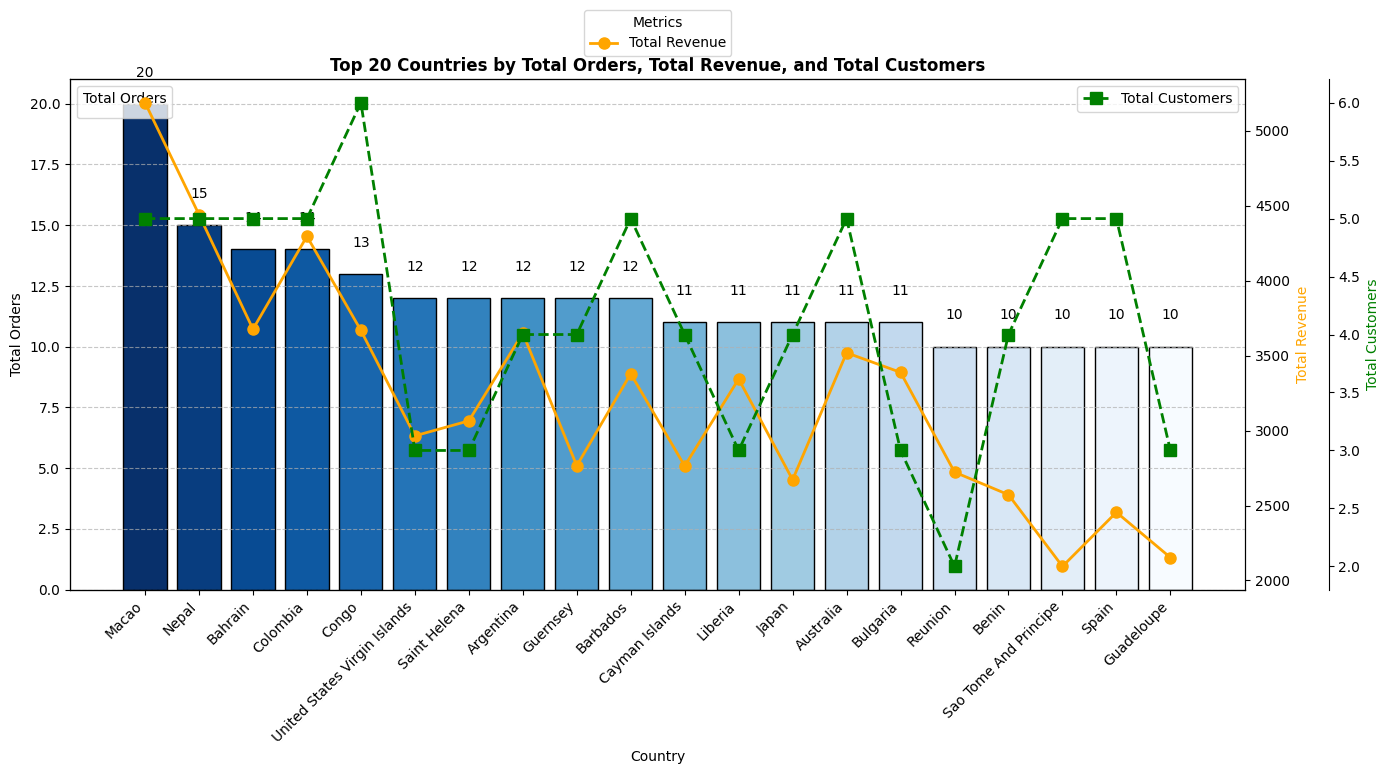

In [10]:
# Step 1: Join transactions with customers to get country information
customer_details_df = customers_df.select("Customer_ID", "Country")
customer_behavior_df = transactions_df.join(customer_details_df, on="Customer_ID", how="inner")

# Step 2: Aggregate the data
country_agg_df = customer_behavior_df.groupBy("Country").agg(
    F.count("Transaction_ID").alias("Total_Orders"),  # Total number of orders
    F.sum("Amount").alias("Total_Revenue"),           # Total revenue (assuming 'Amount' column represents revenue)
    F.countDistinct("Customer_ID").alias("Total_Customers")  # Total number of distinct customers
).orderBy(F.col("Total_Orders").desc())

# Convert to Pandas DataFrame for plotting
country_agg_pd_df = country_agg_df.toPandas()

# Step 3: Sort the data by 'Total_Orders' and take the top 20 countries
top_countries_df = country_agg_pd_df.sort_values(by="Total_Orders", ascending=False).head(20)

# Step 4: Define a colormap for shades of blue
cmap = get_cmap('Blues')
num_countries = len(top_countries_df)
colors = cmap(np.linspace(0, 1, num_countries))[::-1]  # Reverse the colormap
color_dict = dict(zip(top_countries_df['Country'], colors))

# Step 5: Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar plot for Total Orders
bars = ax1.bar(
    top_countries_df['Country'],
    top_countries_df['Total_Orders'],
    color=[color_dict[country] for country in top_countries_df['Country']],
    edgecolor='black'
)

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval + 0.05 * max(top_countries_df['Total_Orders']),
        f'{yval:.0f}',
        ha='center',
        va='bottom'
    )

# Create a second y-axis for Total Revenue
ax2 = ax1.twinx()
lines_total_revenue = ax2.plot(
    top_countries_df['Country'],
    top_countries_df['Total_Revenue'],
    color='orange',
    marker='o',
    linestyle='-',
    linewidth=2,
    markersize=8,
    label='Total Revenue'
)

# Create a third y-axis for Total Customers
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Adjust position to avoid overlap with other axes
lines_total_customers = ax3.plot(
    top_countries_df['Country'],
    top_countries_df['Total_Customers'],
    color='green',
    marker='s',
    linestyle='--',
    linewidth=2,
    markersize=8,
    label='Total Customers'
)

# Customize the layout
ax1.set_xlabel('Country')
ax1.set_ylabel('Total Orders')
ax1.set_title('Top 20 Countries by Total Orders, Total Revenue, and Total Customers', fontweight='bold')
ax1.set_xticklabels(top_countries_df['Country'], rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Set labels for the secondary y-axes
ax2.set_ylabel('Total Revenue', color='orange')
ax3.set_ylabel('Total Customers', color='green')

# Add custom legends
ax1.legend(handles=[bars[0]], title='Total Orders', loc='upper left')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), title='Metrics')
ax3.legend(loc='upper right')

# Adjust layout to make space for the legends
plt.tight_layout()
plt.show()


## 7. Quaterly, Monthly and weekly Trends of Purchasing Behavior

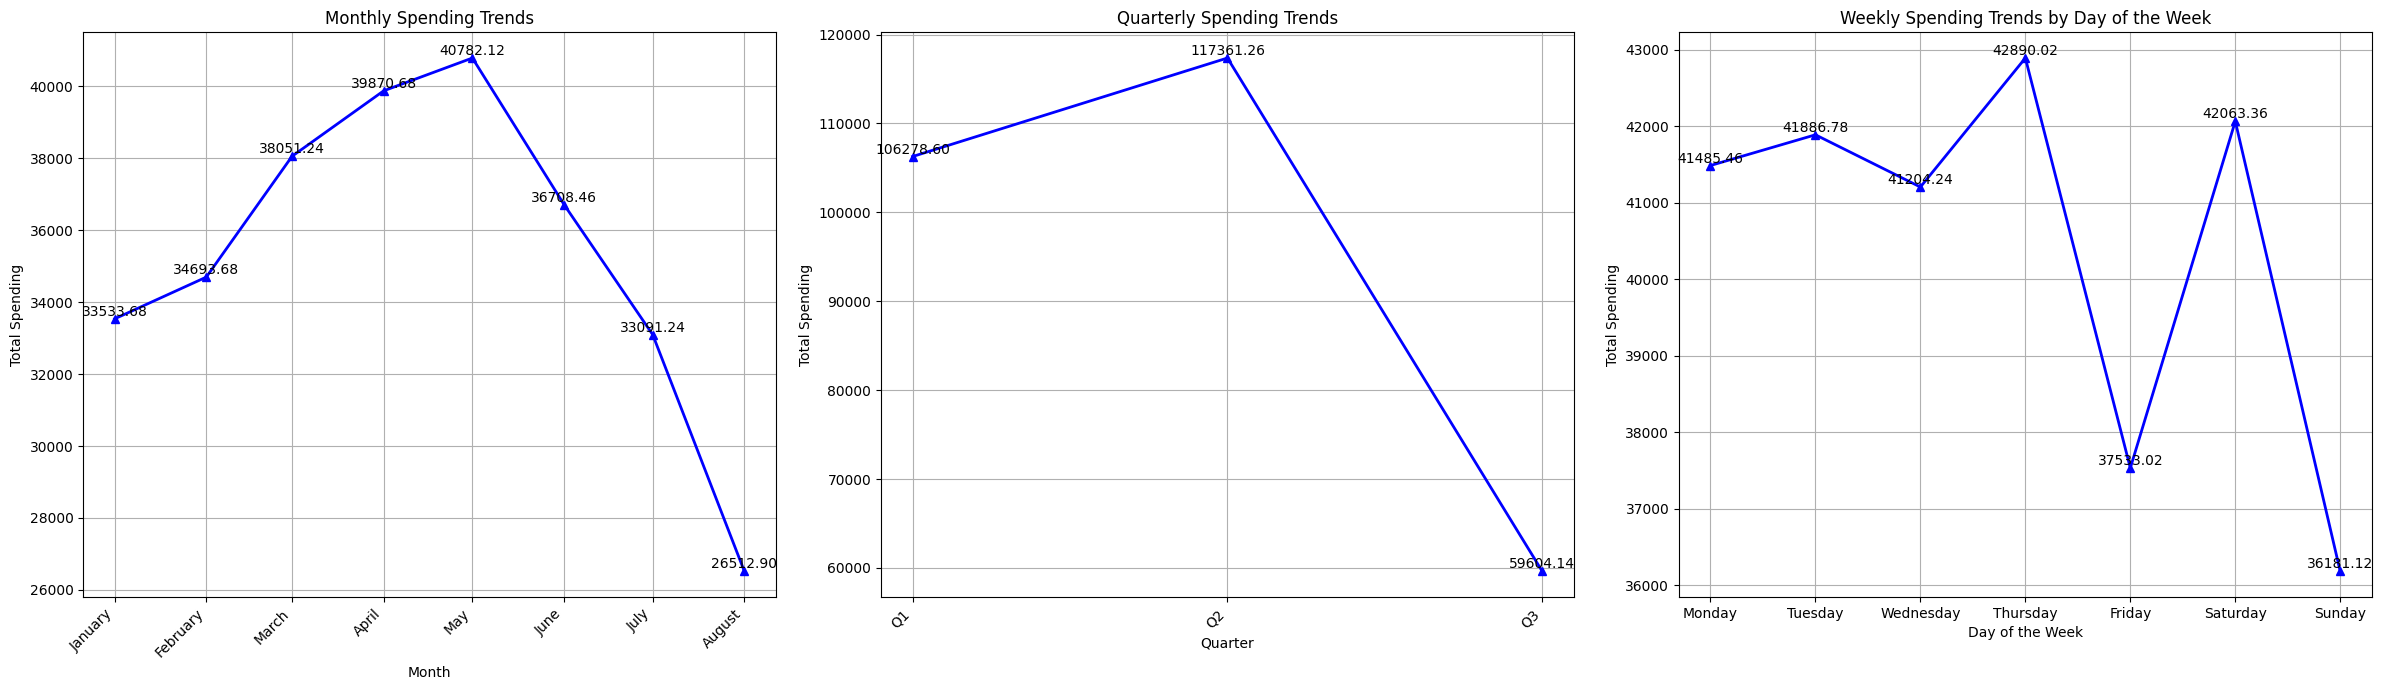

In [11]:
# Convert 'Date' column to date format
transactions_df = transactions_df.withColumn('Date', to_date(col('Date'), 'yyyy-MM-dd'))

# Extract year and month for monthly aggregation
transactions_df = transactions_df.withColumn('Year', F.year(col('Date')))
transactions_df = transactions_df.withColumn('Month', F.month(col('Date')))
transactions_df = transactions_df.withColumn('Month_Name', F.date_format(col('Date'), 'MMMM'))

# Aggregate total spending by year and month
monthly_spending_df = transactions_df.groupBy("Year", "Month", "Month_Name").agg(
    F.round(F.sum("Amount"), 2).alias("Total_Spending")
).orderBy("Year", "Month")

# Convert to Pandas DataFrame for plotting
monthly_spending_pd_df = monthly_spending_df.toPandas()

# Assign a default day (e.g., the first of the month)
monthly_spending_pd_df['Date'] = pd.to_datetime(monthly_spending_pd_df[['Year', 'Month']].assign(Day=1))

# Extract year and quarter for quarterly aggregation
transactions_df = transactions_df.withColumn('Quarter', F.quarter(col('Date')))

# Aggregate total spending by year and quarter
quarterly_spending_df = transactions_df.groupBy("Year", "Quarter").agg(
    F.round(F.sum("Amount"), 2).alias("Total_Spending")
).orderBy("Year", "Quarter")

# Convert to Pandas DataFrame for plotting
quarterly_spending_pd_df = quarterly_spending_df.toPandas()

# Assign a default month and day for each quarter (e.g., the first day of the first month in the quarter)
quarterly_spending_pd_df['Date'] = pd.to_datetime(quarterly_spending_pd_df[['Year']].assign(
    Month=quarterly_spending_pd_df['Quarter']*3 - 2, Day=1))

# Extract day of the week for weekly aggregation (7 days of the week)
transactions_df = transactions_df.withColumn('Day_Of_Week', date_format(col('Date'), 'EEEE'))

# Aggregate total spending by day of the week
weekly_spending_df = transactions_df.groupBy("Day_Of_Week").agg(
    F.round(F.sum("Amount"), 2).alias("Total_Spending")
).orderBy(F.expr("case when Day_Of_Week = 'Monday' then 1 " 
                 "when Day_Of_Week = 'Tuesday' then 2 "
                 "when Day_Of_Week = 'Wednesday' then 3 "
                 "when Day_Of_Week = 'Thursday' then 4 "
                 "when Day_Of_Week = 'Friday' then 5 "
                 "when Day_Of_Week = 'Saturday' then 6 "
                 "when Day_Of_Week = 'Sunday' then 7 "
                 "else 8 end"))

# Convert to Pandas DataFrame for plotting
weekly_spending_pd_df = weekly_spending_df.toPandas()

# Create subplots for side-by-side visualization
fig, axs = plt.subplots(1, 3, figsize=(24, 7))

# Plot monthly spending trends
axs[0].plot(
    monthly_spending_pd_df['Date'],
    monthly_spending_pd_df['Total_Spending'],
    marker='^',  # Filled triangle marker
    linestyle='-', 
    color='blue',
    linewidth=2
)
axs[0].set_title('Monthly Spending Trends')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Total Spending')
axs[0].grid(True)
axs[0].set_xticks(monthly_spending_pd_df['Date'])
axs[0].set_xticklabels(monthly_spending_pd_df['Month_Name'], rotation=45, ha='right')

# Add labels on top of dots for monthly spending
for i in range(len(monthly_spending_pd_df)):
    axs[0].text(
        monthly_spending_pd_df['Date'].iloc[i], 
        monthly_spending_pd_df['Total_Spending'].iloc[i], 
        f'{monthly_spending_pd_df["Total_Spending"].iloc[i]:.2f}', 
        ha='center', 
        va='bottom'
    )

# Plot quarterly spending trends
axs[1].plot(
    quarterly_spending_pd_df['Date'],
    quarterly_spending_pd_df['Total_Spending'],
    marker='^',  # Filled triangle marker
    linestyle='-', 
    color='blue',
    linewidth=2
)
axs[1].set_title('Quarterly Spending Trends')
axs[1].set_xlabel('Quarter')
axs[1].set_ylabel('Total Spending')
axs[1].grid(True)
axs[1].set_xticks(quarterly_spending_pd_df['Date'])
axs[1].set_xticklabels([f'Q{q}' for q in quarterly_spending_pd_df['Quarter']], rotation=45, ha='right')

# Add labels on top of dots for quarterly spending
for i in range(len(quarterly_spending_pd_df)):
    axs[1].text(
        quarterly_spending_pd_df['Date'].iloc[i], 
        quarterly_spending_pd_df['Total_Spending'].iloc[i], 
        f'{quarterly_spending_pd_df["Total_Spending"].iloc[i]:.2f}', 
        ha='center', 
        va='bottom'
    )

# Plot weekly spending trends by day of the week
axs[2].plot(
    weekly_spending_pd_df['Day_Of_Week'],
    weekly_spending_pd_df['Total_Spending'],
    marker='^',  # Filled triangle marker
    linestyle='-', 
    color='blue',
    linewidth=2
)
axs[2].set_title('Weekly Spending Trends by Day of the Week')
axs[2].set_xlabel('Day of the Week')
axs[2].set_ylabel('Total Spending')
axs[2].grid(True)

# Add labels on top of dots for weekly spending
for i in range(len(weekly_spending_pd_df)):
    axs[2].text(
        weekly_spending_pd_df['Day_Of_Week'].iloc[i], 
        weekly_spending_pd_df['Total_Spending'].iloc[i], 
        f'{weekly_spending_pd_df["Total_Spending"].iloc[i]:.2f}', 
        ha='center', 
        va='bottom'
    )

# Adjust layout to make space for labels and titles
plt.tight_layout()
plt.show()


In [12]:
weekly_spending_pd_df

,Day_Of_Week,Total_Spending
0,Monday,41485.46
1,Tuesday,41886.78
2,Wednesday,41204.24
3,Thursday,42890.02
4,Friday,37533.02
5,Saturday,42063.36
6,Sunday,36181.12


In [13]:
monthly_spending_pd_df

,Year,Month,Month_Name,Total_Spending,Date
0,2024,1,January,33533.68,2024-01-01
1,2024,2,February,34693.68,2024-02-01
2,2024,3,March,38051.24,2024-03-01
3,2024,4,April,39870.68,2024-04-01
4,2024,5,May,40782.12,2024-05-01
5,2024,6,June,36708.46,2024-06-01
6,2024,7,July,33091.24,2024-07-01
7,2024,8,August,26512.90,2024-08-01
